# Parking Analysis Calculations

This file calculates parking stats for lots (everything besides street parking).

## Setup

[OSMnx](https://github.com/gboeing/osmnx) is used to download and manipulate data from [OpenStreetMap](https://www.openstreetmap.org/#map=15/41.8222/-71.4085) (OSM).

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from functools import reduce
from measurement.measures import Area
from decimal import Decimal
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11'

Specify the area to look for and the type of footprints to look for. Here, we only want the Downtown Neighborhood, and we are only looking for footprints tagged as "amenity:parking" in OSM.

**Note:** You must supply a `place` string which returns a valid result in OSM. For this calculation, I manually had to create the "Dowtown" neighborhood from the [City's GIS](http://pvdgis.maps.arcgis.com/home/webmap/viewer.html?useExisting=1&layers=07555d51a34a4fa0a43e9c920f68970f). Other neighborhoods may or may not be on OSM. For example, Fox Point and College Hill are, but Upper South Providence is not.

In [2]:
place = "Downtown, Providence, RI, USA"

Because of the way OSM stores data and OSMnx retrieves it, we need to handle street parking separately from how we handle parking in lots, whether they be surface, underground, or multi-level.

### Lot Parking

We will use OSMnx to download "footprints." These are effectively polygons representing the shapes of lots in the neighborhood. Each shape is "tagged" (in OSM parlance) with various bits of information (surface type, capacity, etc.).

For OSMnx to retrieve the right footprints, we need to specify a type:

In [3]:
footprint_type = "parking"

Download the footprints from OSM, and them project them to UTM 19 via OSMnx (UTM Zone selected automatically):

In [4]:
footprints_unprojected = ox.footprints.footprints_from_place(place, footprint_type=footprint_type)
footprints = ox.project_gdf(footprints_unprojected)

`footprints_from_place` and `project_gdf` return GeoPandas `GeoDataFrame`s. Examine the first few entries of the latter:

In [5]:
footprints.head()

,nodes,highway,name,oneway,parking,surface,geometry,lanes,tiger:cfcc,tiger:reviewed,...,description,fee,building:levels,lit,parking:lane:both,tiger:name_direction_prefix,smoothness,maxspeed,members,type
121498413,"[1359954107, 1359954080, 1359954126, 135995408...",NaN,Rhode Island Convention Center,NaN,multi-storey,NaN,"POLYGON ((299344.171 4633139.476, 299344.231 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535719,"[1549239929, 1549239995, 1549239920, 154923986...",NaN,Biltmore Garage,NaN,multi-storey,NaN,"POLYGON ((299480.300 4633065.483, 299518.656 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535724,"[1549239764, 3190088397, 1549239673, 154923959...",NaN,NaN,NaN,multi-storey,NaN,"POLYGON ((299920.958 4632965.162, 299927.951 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535769,"[1549239670, 7105448142, 7105448141, 154923954...",NaN,NaN,NaN,multi-storey,concrete:lanes,"POLYGON ((299345.605 4632950.568, 299388.869 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535777,"[1549239863, 7107873191, 1549239787, 154923972...",NaN,NaN,NaN,multi-storey,NaN,"POLYGON ((299862.573 4633016.029, 299886.587 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And take a look at the geometries (stored as [Shapely Polygons](https://shapely.readthedocs.io/en/stable/manual.html#polygons)).

In [6]:
footprints.geometry.head()

121498413    POLYGON ((299344.171 4633139.476, 299344.231 4...
141535719    POLYGON ((299480.300 4633065.483, 299518.656 4...
141535724    POLYGON ((299920.958 4632965.162, 299927.951 4...
141535769    POLYGON ((299345.605 4632950.568, 299388.869 4...
141535777    POLYGON ((299862.573 4633016.029, 299886.587 4...
Name: geometry, dtype: geometry

And plot these as well, using OSMnx's `plot_footprints` function:

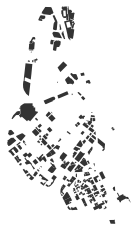

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x125631390>)

In [7]:
ox.footprints.plot_footprints(footprints, save=True, filename="all_lots")

### Street Parking

Streets are defined as "ways" in OSM. Ideally, we would be able to pull these from OSM using the `osmnx.pois` module, but this is not currently possible because `osmnx.pois.create_poi_gdf` filters the dataset using the OSM `amenity` tag, which won't work since street parking is defined with the `parking:lane` tag. **Note:** [there is discussion](https://github.com/gboeing/osmnx/pull/342) on changing this in a future release of OSMnx.

Instead, we will get *all* OSM data as JSON, and filter to the ways we want.

First, we use `ox.gdf_from_place` to retrieve the geometry of the Downtown neighborhood:

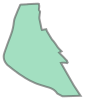

In [8]:
downtown_poly = ox.gdf_from_place("Downtown, Providence, RI, USA").geometry[0]
downtown_poly

Next, we extract the elements from this download, and filter:

In [9]:
download = ox.osm_net_download(polygon=downtown_poly)[0]['elements']

def is_way_with_parking(element):
    match_tags = ['parking:lane:both', 'parking:lane:left', 'parking:lane:right']
    
    val = element['type'] == 'way'
    val &= 'tags' in element and any(k in match_tags for k in element['tags'].keys())
    
    return val

filtered = list(filter(is_way_with_parking, download))

Next, we use a Pandas `DataFrame` to store useful values from that JSON.

**Note:** this is Pandas, not GeoPandas. Currently, we are not storing any geospatial information about the streets.

In [10]:
street_parking = pd.DataFrame()

for f in filtered:
        osmid = f['id']
        tags = f.get('tags', {})
        tags_to_copy = ['surface', 'highway', 'lanes', 'oneway', 'parking', 'name']
        for t in tags.keys():
            if any(t.startswith(c) for c in tags_to_copy):
                if t.endswith(":capacity"):
                    tags[t] = int(tags[t])
                street_parking.loc[osmid, t] = tags[t]

street_parking.head()

,highway,name,oneway,parking:lane:right,parking:lane:right:capacity,surface,parking:lane:both,parking:lane:both:capacity,parking:lane:left,parking:lane:left:capacity,lanes,lanes:backward,lanes:forward,parking:lane:left:parallel,parking:lane:right:parallel,name_1,parking:lane:both:parallel,parking,oneway:bicycle
19352934,residential,Abbott Park Place,yes,parallel,8.0,asphalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19357901,unclassified,Imperial Place,NaN,NaN,NaN,asphalt,parallel,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19357921,primary,Washington Place,yes,NaN,NaN,asphalt,NaN,NaN,parallel,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359927,unclassified,Exchange Street,NaN,NaN,NaN,asphalt,NaN,NaN,parallel,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359928,unclassified,Exchange Street,NaN,parallel,4.0,asphalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we filter out everything except the capacity columns... these are what we care about right now.

In [11]:
capacity_tags = ['parking:lane:right:capacity', 'parking:lane:left:capacity', 'parking:lane:both:capacity']
street_lane_capacities = street_parking[capacity_tags]
street_lane_capacities.head()

,parking:lane:right:capacity,parking:lane:left:capacity,parking:lane:both:capacity
19352934,8.0,NaN,NaN
19357901,NaN,NaN,10.0
19357921,NaN,6.0,NaN
19359927,NaN,4.0,NaN
19359928,4.0,NaN,NaN


Now, we sum horizontally:

In [12]:
street_capacities = pd.DataFrame()
street_capacities['total'] = street_lane_capacities.sum(axis=1)
street_capacities.head()

,total
19352934,8.0
19357901,10.0
19357921,6.0
19359927,4.0
19359928,4.0


And sum again to get the **total number of on-street parking spaces:**

In [13]:
total_street_capacity = int(street_capacities.sum()['total'])
total_street_capacity

2163

## Calculations

### Land use

First, we calculate the total area of the neighborhood. First, we must project the polygon from CRS to UTM, again via OSMnx. We then extract the area in square meters:

In [14]:
project_downtown_poly, _ = ox.project_geometry(downtown_poly)
downtown_area = project_downtown_poly.area

We'll do calculations in square meters for now, and then use this `convert_area` function to convert the area (via [python-measurement](https://github.com/coddingtonbear/python-measurement)) and round later on:

In [15]:
def convert_area(sq_meters, decimals=2):
    area_obj = Area(sq_m=sq_meters)
    return float(round(Decimal(area_obj.sq_mi), decimals))

convert_area(downtown_area)

0.78

Now, let's prepare a `GeoDataFrame` for land use calculations.

Start by getting the footprints of surface lots, joining them into a single shape with a GeoPandas `unary_union`, and saving the area into the frame:

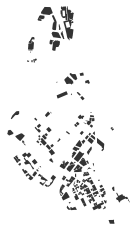

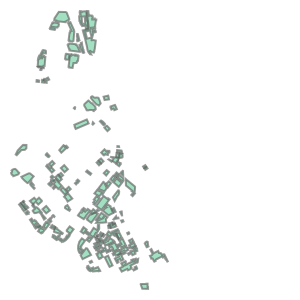

In [16]:
land_use = gpd.GeoDataFrame(columns=['type', 'geometry', 'area'])
land_use.set_geometry('geometry')

footprints_surface = footprints.query('parking=="surface"')

ox.plot_footprints(footprints_surface, save=True, filename="surface_lots")

footprints_surface_combined = footprints_surface.geometry.unary_union
land_use.loc['surface'] = ['surface', footprints_surface_combined, footprints_surface_combined.area]

footprints_surface_combined

*Notice:* Some of the larger lots like the Mall and Convention Center are now not shown, but there is a *lot* of small surface lots in the Jewelery District and a lot of large surface lots near the State House and State offices.

Do the same for structured parking (defined here as not `surface`):

In [17]:
footprints_structured = footprints.query('parking!="surface"')

footprints_structured_combined = footprints_structured.geometry.unary_union
land_use.loc['structured'] = ['structured', footprints_structured_combined, footprints_structured_combined.area]

land_use

,type,geometry,area
surface,surface,"MULTIPOLYGON (((300130.227 4631984.396, 300177...",251990.114271
structured,structured,"MULTIPOLYGON (((299647.813 4632190.896, 299717...",105105.131389


Now, let's calculate the percentage each type takes of all parking area, of total downtown area, and also convert to square miles:

In [18]:
land_use['area_square_miles'] = list(map(lambda x: Area(sq_m=x).sq_mi, land_use['area']))

In [19]:
total_parking_area = land_use['area'].sum()

calc_park_area_percent = lambda x: float(round(Decimal(x / total_parking_area) * 100, 2))
calc_downtown_area_percent = lambda x: float(round(Decimal(x / downtown_area) * 100, 2))

land_use['percent_parking_area'] = list(map(calc_park_area_percent, land_use['area']))
land_use['percent_downtown_area'] = list(map(calc_downtown_area_percent, land_use['area']))

In [20]:
land_use

,type,geometry,area,area_square_miles,percent_parking_area,percent_downtown_area
surface,surface,"MULTIPOLYGON (((300130.227 4631984.396, 300177...",251990.114271,0.097294,70.57,12.49
structured,structured,"MULTIPOLYGON (((299647.813 4632190.896, 299717...",105105.131389,0.040581,29.43,5.21


In [21]:
land_use.drop('type', 1).sum()

area                     357095.245660
area_square_miles             0.137875
percent_parking_area        100.000000
percent_downtown_area        17.700000
dtype: float64

### Capacity

We previously calculated the capacity of street parking:

In [22]:
total_street_capacity

2163

For surface lots, let's filter out lots that don't have set capacities:

In [23]:
surface_lots_no_capacity_set = footprints_surface.query('capacity==None')

surface_lots_no_capacity_set['capacity']

Series([], Name: capacity, dtype: object)

There's nothing here! This is good... it means all the lots in OpenStreetMap have been properly marked with a `capacity` tag.

We'll take the rest of the lots (with `capacity` defined), and sum their total disability and any spaces which have been marked as [ADA Handicapped parking](https://www.ada.gov/restriping_parking/restriping2015.html).

In [24]:
fields_to_retain = ['name', 'surface','capacity', 'capacity:disabled']
fields_to_convert_to_numerics = ['capacity', 'capacity:disabled']

surface_lots_capacity_set = footprints_surface.query('capacity!=None')[fields_to_retain]

def columns_to_numerics(df, fields):
    for field in fields:
        df[field] = pd.to_numeric(df[field])

columns_to_numerics(surface_lots_capacity_set, fields_to_convert_to_numerics)

total_surface_capacity = int(surface_lots_capacity_set['capacity'].sum())
disabled_surface_capacity = int(surface_lots_capacity_set['capacity:disabled'].sum())

Now, let's put it together into a frame:

In [25]:
capacities = pd.DataFrame(columns=['type', 'total', 'regular', 'disabled'])

capacities.loc['street'] = ['street', total_street_capacity, total_street_capacity, None]
capacities.loc['surface'] = ['surface', total_surface_capacity, total_surface_capacity - disabled_surface_capacity, disabled_surface_capacity]

capacities

,type,total,regular,disabled
street,street,2163,2163,None
surface,surface,8026,7867,159


In [26]:
capacities.drop('type', 1).sum()

total       10189.0
regular     10030.0
disabled      159.0
dtype: float64

**Note:** While the [OSM spec](https://wiki.openstreetmap.org/wiki/Key:parking:lane) does support indicating that on-street parking is accessible with the `parking:lane:[left/right/both]:capacity:disabled` tag, it is not well documented. At present, on-street parking for Downtown Providence has not been recorded in OSM. Were it, the results would be negligible. *Very* few parking spots are physically marked as ADA accessible in the area.

#### More on Accessible Parking

We previously calculated the total number of parking spaces considered to be ADA accessible, as indicated by OSM's `capacity:disabled` tag. Now, let's look at how many lots offer accessible parking:

In [27]:
surface_lots_capacity_disabled_set = surface_lots_capacity_set[surface_lots_capacity_set['capacity:disabled'].notnull()]
count_lots_with_disabled = len(surface_lots_capacity_disabled_set)
count_lots_with_disabled

54

Now, calculate the average number of disabled spots per lot that has *any* disabled spots:

In [28]:
surface_disabled_spots_per_all_lot = capacities['disabled'].sum() / len(surface_lots_capacity_set)
surface_disabled_spots_per_all_lot

0.8548387096774194

In [29]:
surface_disabled_spots_per_disabled_lot = capacities['disabled'].sum() / count_lots_with_disabled
surface_disabled_spots_per_disabled_lot

2.9444444444444446

## Saving Data

Right now, we save the data to a markdown file at [`../outputs.md`](../outputs.md).

In [30]:
output_filename = '../outputs.md'

from tabulate import tabulate

def df_to_markdown(df, y_index=False):
    if 'geometry' in df:
        df = df.drop('geometry', 1)
    blob = tabulate(df, headers='keys', tablefmt='pipe')
    if not y_index:
        return '\n'.join(['| {}'.format(row.split('|', 2)[-1]) for row in blob.split('\n')])
    return blob

In [31]:
output_contents = []

output_contents.append('# Outputs')

output_contents.append('## Capacites')
capacities.loc['TOTAL'] = capacities.drop('type', 1).sum()
capacities.loc['TOTAL', 'type'] = 'TOTAL'
output_contents.append(df_to_markdown(capacities))

output_contents.append('## Land Use')
land_use.loc['TOTAL'] = land_use.drop('type', 1).sum()
land_use.loc['TOTAL', 'type'] = 'TOTAL'
output_contents.append(df_to_markdown(land_use))

output_contents.append('## Additional Counts')
output_contents.append('- % of Surface Lots with `capacity:disabled` set: `{}`'.format(count_lots_with_disabled / len(surface_lots_capacity_set) * 100))
output_contents.append('\t- Number of Surface Lots with `capacity` set: `{}`'.format(len(surface_lots_capacity_set)))
output_contents.append('\t- Number of Surface Lots with `capacity:disabled` set: `{}`'.format(count_lots_with_disabled))
output_contents.append('- number of disabled spaces per *all* surface lots with `capacity` set: `{}`'.format(surface_disabled_spots_per_all_lot))
output_contents.append('- number of disabled spaces per surface lots with `capacity:disabled` set: `{}`'.format(surface_disabled_spots_per_disabled_lot))

output_contents.append('## Images')
output_contents.append('all_lots.png')
output_contents.append('![Image does not exist](./notebooks/images/all_lots.png "All Lots")')
output_contents.append('surface_lots.png')
output_contents.append('![Image does not exist](./notebooks/images/surface_lots.png "Surface Lots")')

In [32]:
with open('../outputs.md', 'w+') as fn:
    for line in output_contents:
        fn.write(line + "\n\n")